<a href="https://colab.research.google.com/github/upasana-crypto/seizure/blob/main/Copy_of_global.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [9]:
try: 
    import pyedflib
except:
    !pip install pyedflib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 2.7 MB/s 


In [10]:
import pyedflib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import os
import warnings 
import random
import collections
from numpy.random import seed
import torch
import torch.utils as utils
import torch.utils.data as data
from os import path
import pandas as pd

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
warnings.filterwarnings("ignore")
pathDataSet = '/content/drive/MyDrive/upsi-seizure/data/CHB-MIT/'
processed_data_path = '/content/drive/MyDrive/upsi-seizure/data/CHB-MIT_filtered/'
channels = ['FP1-F7', 'F7-T7','T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ','P7-T7','T7-FT9','FT9-FT10','FT10-T8']
patients = ["10" ]#, "07", "08"]
            #, "09", "10"]

In [12]:
def loadSummaryPatient(index):
  f = open(pathDataSet+'chb'+patients[index]+'/chb'+patients[index]+'-summary.txt', 'r') 
  parent = pathDataSet+'chb'+patients[index]+'/'
  return f, parent

In [13]:
def readEdfFile(pathToFile, channels):
    f = pyedflib.EdfReader(pathToFile)
    n = f.signals_in_file
    #print(n)
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((f.getNSamples()[0],n))
    for i in np.arange(n): 
        sigbufs[:,i] = f.readSignal(i)
    #sigbufs[:, n]= 0.0
    df =  pd.DataFrame(data = sigbufs, columns = signal_labels)
    #print(df.shape)
    df = df.loc[:, channels]
    #print(df.shape)
    df = df.loc[:, ~df.columns.duplicated()]
    #print(df.shape)
    f._close()
    del f
    data = df.values
    #data_numpy = data.to_numpy()
    return np.transpose(data)

In [14]:
import numpy as np
from scipy.signal import butter, sosfilt, sosfreqz
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y
lowcut = 0.5
highcut = 50           #30
fs = 256
# x_filter = butter_bandpass_filter(features ,lowcut , highcut , fs , order = 5)
# mean1 = np.mean(x_filter) 
# std = np.std(x_filter)
# x_filter_normalized = (x_filter - mean1)/ std

In [15]:
def seizureNumpyMatrixGenerate(secSt, secEn, name_F, parent, index):
  file1 = pyedflib.EdfReader(parent+name_F)
  n = file1.signals_in_file
  rate =256
  col = file1.getNSamples()[0]
  # print(n)
  #signal_labels = file1.getSignalLabels()
  #signal_headers = file1.getSignalHeaders()
  #rate = signal_headers[0]['sample_rate']
  dur = file1.getFileDuration()
  #print(type(dur))
  #print(f'Duration of this trial {dur}')
  file1._close()
  del file1
  x = np.zeros((n, col))
  #for i in range(n):
    #x[i,:] = file1.readSignal(i)
  x = readEdfFile(parent+name_F, channels)
    # print(x)
    #label = file1.getLabel(i)
 
 
  #x_filter = butter_bandpass_filter(x ,lowcut , highcut , fs , order = 5)
  #a = os.getcwd()
  folder_path= processed_data_path + 'chb'+ patients[index] + '/'
  if os.path.isdir(processed_data_path) is not True:
    os.makedirs(processed_data_path)
  subfolder_path = folder_path + name_F.split('.')[0] + '/'
  if os.path.isdir(subfolder_path) is not True:
    os.makedirs(subfolder_path)
  else:
    print('folder already exists') 
    #print(subfolder_path)
  picnum = int(dur*rate/256)
  #print(picnum)
  num_seizure = 0
  num_nonseizure = 0
  for i in range(picnum):
    img = x[:,i*256:(i+1)*256]
    x_filter = butter_bandpass_filter(img ,lowcut , highcut , fs , order = 5)
    #img = (img - np.min(img))/(np.max(img) - np.min(img))
    #Img = Image.fromarray(np.uint8(img))
    # print(len(secSt))
    if len(secSt) ==0:
        name = 'nonseizure'
        num_nonseizure +=1
    elif len(secSt) == 1:
      if secSt[0] <= i+1 <= secEn[0]: #window size is 1sec
          name = 'seizure'
          num_seizure+=1
      else:
          name = 'nonseizure'
          num_nonseizure +=1
      #print('1 seizure interval present')
    elif len(secSt) == 2:
      if secSt[0] <= i+1 <= secEn[0] or secSt[1] <= i+1 <= secEn[1]: #window size is 1sec
          name = 'seizure'
          num_seizure+=1
      else:
          name = 'nonseizure' 
          num_nonseizure +=1
      #print('2 seizure intervals present')
    elif len(secSt) == 3:
      if secSt[0] <= i+1 <= secEn[0] or secSt[1] <= i+1 <= secEn[1] or secSt[2] <= i+1 <= secEn[2]: #window size is 1sec
          name = 'seizure'
          num_seizure+=1
      else:
          name = 'nonseizure'
          num_nonseizure +=1
      #print('3 seizure intervals present')
    else: 
      if secSt[0] <= i+1 <= secEn[0] or secSt[1] <= i+1 <= secEn[1] or secSt[2] <= i+1 <= secEn[2] or secSt[3] <= i+1 <= secEn[3]:
          name = 'seizure'
          num_seizure+=1
      else:
          name = 'nonseizure'
          num_nonseizure +=1
      #print('4 seizure intervals present')
        

    if i+1 < 10:
        filename = 'time_'+name+'_0000'+ str(i+1)
    elif 10 <= i+1 < 100:
        filename = 'time_'+name+'_000'+ str(i+1)
    elif 100 <= i+1 < 1000:
        filename = 'time_'+name+'_00'+ str(i+1)
    elif 1000 <= i+1 < 10000:
        filename = 'time_'+name+'_0'+ str(i+1)
    else:
        filename = 'time_'+name+'_'+ str(i+1)
    if path.exists(subfolder_path+ filename+'.npy'):
      continue
    # else:
    #   np.save(subfolder_path + filename+'.npy', x_filter)
        # print('-')
      # continue
      
  


  return (num_seizure, num_nonseizure, num_seizure+num_nonseizure, dur)

In [16]:
def createDataset():
    
    seizure_trials = {}
    total_duration = {}
    total_seizure = []
    total_nonseizure = []
    durations = []
    num =0
    print("START \n")
    for indexPatient in range(0, len(patients)):
        seizure_num_per_patient = []
        nonseizure_num_per_patient = []
        values = []
        key = 'chb'+patients[indexPatient]
        #print(indexPatient)
        f, parent = loadSummaryPatient(indexPatient)
        line=f.readline()
        #print(' i was here')
        
        while (line):
            data=line.split(':')
            #print(data)
            if (data[0]=="File Name"):
                name_F=data[1].strip()
                
                #print(name_F)
                fileSt=f.readline().split(': ')[1]
                # Sthr=fileSt.split(':')[0]
                # #print(Sthr)
                # Stmin=fileSt.split(':')[1]
                # #print(Stmin)
                # Stsec=fileSt.split(':')[2]
                # #print(Stsec)
                fileEn=f.readline().split(': ')[1]
                # Enhr=fileEn.split(':')[0]
                # #print(Enhr)
                # Enmin=fileSt.split(':')[1]
                # #print(Enmin)
                # Ensec=fileSt.split(':')[2]
                # #print(Ensec)
                # trial_duration = ((int(Enhr) - int(Sthr))*3600 + (int(Enmin) - int(Stmin))*60 + (int(Ensec) - int(Stsec)))
                
                # print(trial_duration)
                for i in range(1):
                    line=f.readline()
                secSt = []
                secEn = []
                # if num<2:
                #     if int(line.split(': ')[1]) == 0:
                #         secStnonseizure = []
                #         secEnnonseizure = []
                #         num+=1
                #         value = name_F
                #         print(name_F)
                #         values.append(value)
                #         key1 = name_F
                #         seizure_num_per_trial, nonseizure_num_per_trial, total_samples, dur = seizureNumpyMatrixGenerate(secStnonseizure, secEnnonseizure, name_F, parent, indexPatient)   # creates numpy matrices for 1 s windows
                #         durations.append(dur)
                #         total_duration[key1]= dur
                #         #type(dur)
                #         print(f'No. of seizure samples : {seizure_num_per_trial}, No. of non-seizure samples : {nonseizure_num_per_trial}, Total no. of samples : {seizure_num_per_trial + nonseizure_num_per_trial}')
                #         #seizure_num_per_trial.append(num_seizure)
                #         #print(seizure_num_per_trial)
                #         #nonseizure_num_per_trial.append(num_nonseizure)
                #         #print(nonseizure_num_per_trial)
                #         seizure_num_per_patient.append(seizure_num_per_trial)
                #         nonseizure_num_per_patient.append(nonseizure_num_per_trial) 
                
                for j in range(0, int(line.split(': ')[1])):
                    if j==0:
                        print(f'trial : {name_F}')
                        value = name_F
                        values.append(value)
                        key1 = name_F            
                    secSt.append(int(f.readline().split(': ')[1].split(' ')[0]))
                    #print(f'Start second of seizure {secSt}')
                    secEn.append(int(f.readline().split(': ')[1].split(' ')[0]))
                    #print(f'Start second of seizure {secEn}')
                if int(line.split(': ')[1]) != 0:
                    seizure_num_per_trial, nonseizure_num_per_trial, total_samples, dur = seizureNumpyMatrixGenerate(secSt, secEn, name_F, parent, indexPatient)   # creates numpy matrices for 1 s windows
                    durations.append(dur)
                    total_duration[key1]= dur
                    #type(dur)
                    print(f'No. of seizure samples : {seizure_num_per_trial}, No. of non-seizure samples : {nonseizure_num_per_trial}, Total no. of samples : {seizure_num_per_trial + nonseizure_num_per_trial}')
                    #seizure_num_per_trial.append(num_seizure)
                    #print(seizure_num_per_trial)
                    #nonseizure_num_per_trial.append(num_nonseizure)
                    #print(nonseizure_num_per_trial)
                    seizure_num_per_patient.append(seizure_num_per_trial)
                    nonseizure_num_per_patient.append(nonseizure_num_per_trial)
            seizure_trials[key] = values,durations
            #print(durations)
            #duration_per_patient[key] = durations
            line=f.readline()
        f.close()
        
        # print(seizure_num_per_patient)
        # print(nonseizure_num_per_patient)
        # total_seizure.append(np.sum(seizure_num_per_patient))
        # print(total_seizure)
        # total_nonseizure.append(np.sum(nonseizure_num_per_patient))
        # print(total_nonseizure)

    print("END \n")
    return seizure_trials, total_duration, np.sum(total_seizure), np.sum(total_nonseizure)
#, duration_per_patient

In [17]:
seizure_trials, total_duration, total_duration_seizure, total_duration_nonseizure = createDataset()

START 

trial : chb10_12.edf
folder already exists
No. of seizure samples : 36, No. of non-seizure samples : 7164, Total no. of samples : 7200
trial : chb10_20.edf
folder already exists
No. of seizure samples : 71, No. of non-seizure samples : 7141, Total no. of samples : 7212
trial : chb10_27.edf
folder already exists
No. of seizure samples : 66, No. of non-seizure samples : 7152, Total no. of samples : 7218
trial : chb10_30.edf
folder already exists
No. of seizure samples : 59, No. of non-seizure samples : 7154, Total no. of samples : 7213
trial : chb10_31.edf
folder already exists
No. of seizure samples : 77, No. of non-seizure samples : 7144, Total no. of samples : 7221
trial : chb10_38.edf
folder already exists
No. of seizure samples : 90, No. of non-seizure samples : 7110, Total no. of samples : 7200
trial : chb10_89.edf
folder already exists
No. of seizure samples : 55, No. of non-seizure samples : 7145, Total no. of samples : 7200
END 



## Lying around code

In [ ]:
print(seizure_trials['chb10'][0], total_duration)

['chb10_12.edf', 'chb10_20.edf', 'chb10_27.edf', 'chb10_30.edf', 'chb10_31.edf', 'chb10_38.edf', 'chb10_89.edf'] {'chb10_12.edf': 7200, 'chb10_20.edf': 7212, 'chb10_27.edf': 7218, 'chb10_30.edf': 7213, 'chb10_31.edf': 7221, 'chb10_38.edf': 7200, 'chb10_89.edf': 7200}


In [ ]:
seizure_trials = {'chb01': (['chb01_03.edf', 'chb01_26.edf'], [3600, 2325])}
total_duration = {'chb01_03.edf' : 3600, 'chb01_26.edf' : 2325}

In [ ]:
seizure_trials = {'chb03': ([ 'chb03_01.edf', 'chb03_36.edf'],[3600, 3600])}
total_duration = {'chb03_01.edf': 3600, 'chb03_36.edf': 3600}

## Print trials

In [ ]:
print(seizure_trials, total_duration)

{'chb10': (['chb10_12.edf', 'chb10_20.edf', 'chb10_27.edf', 'chb10_30.edf', 'chb10_31.edf', 'chb10_38.edf', 'chb10_89.edf'], [7200, 7212, 7218, 7213, 7221, 7200, 7200])} {'chb10_12.edf': 7200, 'chb10_20.edf': 7212, 'chb10_27.edf': 7218, 'chb10_30.edf': 7213, 'chb10_31.edf': 7221, 'chb10_38.edf': 7200, 'chb10_89.edf': 7200}


In [19]:
def last_5chars(x): #function to sort the numbers in filename so that they can be grouped sequentially
  #print(x[-4])
  return(x[-9:-3])

## normal

In [ ]:
def create_feature_matrix_old(seizure_trials, seizure_trial_duration, folder_path, window_size, total_duration):
  feature_size = np.sum((np.array(seizure_trial_duration)/window_size).astype(int))
  label_size = np.sum((np.array(seizure_trial_duration)/window_size).astype(int))
  features = np.zeros((feature_size,22,256*window_size))
  print(features.shape)
  labels = np.zeros(label_size,dtype=int)
  print(labels.shape)
  i = 0 #the feature index
  group_train = []
  group_test = []
  for trial in seizure_trials:
      print(trial)
      name = sorted(os.listdir(folder_path + trial.split('.')[0]), key= last_5chars)
      #print(name)
      #print(name[952])
      #for window in (range(0, int(total_duration/len(seizure_trials)), window_size)):
      #for window in (range(1, int(len(name)/window_size)*window_size, window_size)):
      for window in (range(0, int(total_duration[trial]/window_size)*window_size, window_size)):       ##########CHECK IF THE LAST NUMBER MAKES SENSE###############
          #print(window)
          seizure = 0
          non_seizure = 0
          feature_prep = np.zeros((22,256*window_size))
          for j in range(window_size):
              if '_seizure_' in name[(window)+j]:
                  #print(name[window+j])
                  seizure+=1
                  #print('seizure no.', seizure)
                  #print('hi')
                  feature_prep[0:23,j*256:((j+1)*256)] = np.array(np.load(folder_path + trial.split('.')[0]+'/'+ name[(window)+j]))[0:23,0:256]
              elif '_nonseizure_' in name[(window)+j]:
                  #print(name[window+j])
                  non_seizure+=1
                  #print('nonseizure no.', non_seizure)
                  #print('nohi')
                  feature_prep[0:23,j*256:((j+1)*256)] = np.array(np.load(folder_path + trial.split('.')[0]+'/'+ name[(window)+j]))[0:23,0:256]
                  #print(feature_prep.shape)
          #print(feature_prep.shape)
          #feature_prep_normalized = (feature_prep - np.min(feature_prep)) / (np.max(feature_prep) -np.min(feature_prep))
          #print('seizure no.', seizure)
          #print('nonseizure no.', non_seizure)
          if seizure > non_seizure:
              #print('label should be 1')
              # features[i] = feature_prep
              labels[i] = 1
              #print(features[i])
              #print(labels[i])
          else:
              #print('label should be 0')
              # features[i] = feature_prep
              labels[i] = 0
              #print(features[i])
              #print(labels[i])
          #print('================================')
          i = i+1
          group_train.append()
      print('finishing one trial')
         # print(features)
         # print(features.shape)
      
   #       print(i)
                  

  #print(i)
    #print(features)
    #print(labels)
    #print(np.expand_dims(np.array(features), axis=3).shape)
    #print(labels.shape)
  if len(seizure_trials)>=2:
    with open('window_'+ str(window_size)+'/patient_specific/'+ str(7)+'/features_train_'+trial.split('_')[0]+'.npy', 'wb') as f:  #
      np.save(f, features)
    f.close
    
    with open('window_'+ str(window_size)+'/patient_specific/'+ str(7) +'/labels_train_'+trial.split('_')[0]+'.npy', 'wb') as f: #
      np.save(f, labels)
    f.close
  else:
    with open('window_'+ str(window_size)+'/patient_specific/'+str(7) +'/features_test_'+trial.split('_')[0]+'.npy', 'wb') as f:  #
      np.save(f, features)
    f.close
    
    with open('window_'+ str(window_size)+'/patient_specific/'+ str(7)+'/labels_test_'+trial.split('_')[0]+'.npy', 'wb') as f: #
      np.save(f, labels)
    f.close
  #dataloader = utils.data.DataLoader(dataset)
    #dataset = np.stack((features,labels), axis = 0)
  #print(dataset.shape)

  return 


## for image like folder

In [47]:
def create_feature_matrix(seizure_trials, seizure_trial_duration,folder_path, window_size, total_duration, train):
  # feature_size = np.sum((np.array(seizure_trial_duration)/window_size).astype(int))
  # label_size = np.sum((np.array(seizure_trial_duration)/window_size).astype(int))
  # features = np.zeros((feature_size,22,256*window_size))
  features_train_df = pd.DataFrame(columns = ['Data', 'Label']) 
  features_test_df = pd.DataFrame(columns = ['Data', 'Label']) 
  #print(features.shape)
  # labels = np.zeros(label_size,dtype=int)
  # print(labels.shape)
  i = 0 #the feature index
  group_train = []
  group_test = []
  for trial in seizure_trials:
      #print(trial)
      name = sorted(os.listdir(folder_path + trial.split('.')[0]), key= last_5chars)
      #print(name)
      #print(name[952])
      #for window in (range(0, int(total_duration/len(seizure_trials)), window_size)):
      #for window in (range(1, int(len(name)/window_size)*window_size, window_size)):
      for window in (range(0, int(total_duration[trial]/window_size)*window_size, window_size)):       ##########CHECK IF THE LAST NUMBER MAKES SENSE###############
          #print(window)
          seizure = 0
          non_seizure = 0
          feature_prep = np.zeros((22,256*window_size))
          for j in range(window_size):
              if '_seizure_' in name[(window)+j]:
                  #print(name[window+j])
                  seizure+=1
                  #print('seizure no.', seizure)
                  #print('hi')
                  feature_prep[0:23,j*256:((j+1)*256)] = np.array(np.load(folder_path + trial.split('.')[0]+'/'+ name[(window)+j]))[0:23,0:256]
              elif '_nonseizure_' in name[(window)+j]:
                  #print(name[window+j])
                  non_seizure+=1
                  #print('nonseizure no.', non_seizure)
                  #print('nohi')
                  feature_prep[0:23,j*256:((j+1)*256)] = np.array(np.load(folder_path + trial.split('.')[0]+'/'+ name[(window)+j]))[0:23,0:256]
                  #print(feature_prep.shape)
          #print(feature_prep.shape)
          #feature_prep_normalized = (feature_prep - np.min(feature_prep)) / (np.max(feature_prep) -np.min(feature_prep))
          #print('seizure no.', seizure)
          #print('nonseizure no.', non_seizure)
          if seizure > non_seizure:
              #print('label should be 1')
              # features[i] = feature_prep
              label = 1
              #print(features[i])
              #print(labels[i])
          else:
              #print('label should be 0')
              # features[i] = feature_prep
              label = 0
              #print(features[i])
              #print(labels[i])
          #print('================================')7
          dest_dir = '/content/drive/MyDrive/upsi-seizure/data/window_size_'+str(window_size)+'/'+str(trial.split('.')[0].split('_')[0])
         # print(features)
         # print(features.shape)
          if len(seizure_trials)>=2:
            if os.path.isdir(dest_dir+'/train') is not True:
                os.makedirs(dest_dir+ '/train')
            if label == 0:
              features_train_df = features_train_df.append({'Data': 'nonseizure_'+ str(i)+'.npy', 'Label': label}, ignore_index = True)
              # with open(dest_dir +'/train/nonseizure_'+ str(i)+'.npy', 'wb') as f:    #######1st and last trials are used for testing#######
              #   np.save(f, feature_prep)
              # f.close
            else:
              features_train_df = features_train_df.append({'Data': 'seizure_'+ str(i)+'.npy', 'Label': label}, ignore_index = True)
              # with open(dest_dir+'/train/seizure_'+ str(i)+'.npy', 'wb') as f:    #######1st and last trials are used for testing#######
              #   np.save(f, feature_prep)
              # f.close
            group_train.append(trial.split('.')[0])
          else:
            if os.path.isdir(dest_dir +'/test') is not True:
              os.makedirs(dest_dir+'/test')
            if label == 0:
              features_test_df = features_test_df.append({'Data': 'nonseizure_'+ str(i)+'.npy', 'Label': label}, ignore_index = True)
              # with open(dest_dir+'/test/nonseizure_'+ str(i)+'.npy', 'wb') as f:    #######1st and last trials are used for testing#######
              #   np.save(f, feature_prep)
              # f.close
            else:
              features_test_df = features_test_df.append({'Data': 'seizure_'+ str(i)+'.npy', 'Label': label}, ignore_index = True)
              # with open(dest_dir+'/test/seizure_'+ str(i)+'.npy', 'wb') as f:    #######1st and last trials are used for testing#######
              #   np.save(f, feature_prep)
              # f.close
            group_test.append(trial.split('.')[0])
              
          i = i+1
  if train is True:
    features_train_df.to_csv(dest_dir+ '/feature_train.csv',index = False)
  else:
    print('hi')
    features_test_df.to_csv(dest_dir+'/feature_test.csv',index = False)
  #dataloader = utils.data.DataLoader(dataset)
    #dataset = np.stack((features,labels), axis = 0)
  #print(dataset.shape)

  return group_train, group_test


In [ ]:
trial = 'chb07_01'
trial.split('.')[0].split('_')[0]

'chb07'

## Train and Test csv and data folder generation


In [ ]:
a = []
for i in (total_duration):
  key, value in total_
  a.append(total_duration[i])

KeyError: ignored

In [42]:
seizure_trials_train = seizure_trials['chb10'][0][0:len(seizure_trials['chb10'][0])-1]
print(seizure_trials_train)
              
window_size = [1,2,4,8,10, 20]
total_duration_train = {'chb10_12.edf': 7200, 'chb10_20.edf': 7212, 'chb10_27.edf': 7218, 'chb10_30.edf': 7213, 'chb10_31.edf': 7221, 'chb10_38.edf': 7200}

seizure_trial_duration = [7200,7212,7218,7213,7221,7200]
folder_path= processed_data_path + 'chb'+ patients[0] + '/'
group_train,_ = create_feature_matrix(seizure_trials_train, seizure_trial_duration, folder_path, window_size[4], total_duration_train, train= True)


['chb10_12.edf', 'chb10_20.edf', 'chb10_27.edf', 'chb10_30.edf', 'chb10_31.edf', 'chb10_38.edf']


In [ ]:
total_duration_train = {item:total_duration.get(item)for item in total_duration.keys()}
total_duration_train

{'chb10_12.edf': 7200,
 'chb10_20.edf': 7212,
 'chb10_27.edf': 7218,
 'chb10_30.edf': 7213,
 'chb10_31.edf': 7221,
 'chb10_38.edf': 7200,
 'chb10_89.edf': 7200}

In [48]:
seizure_trials_test = seizure_trials['chb10'][0][len(seizure_trials['chb10'][0])-1:len(seizure_trials['chb10'][0])]
print(seizure_trials_test)                
window_size = [1,2,4,8,10, 20]
#index = 0
# total_duration_train = {item:total_duration.get(item)for item in total_duration.keys()}
total_duration_test = {

 'chb10_89.edf': 7200
}

seizure_trial_duration_test = [7200]
folder_path= processed_data_path + 'chb'+ patients[0] + '/'

_,group_test = create_feature_matrix(seizure_trials_test, seizure_trial_duration_test, folder_path, window_size[3], total_duration_test, train = False)

['chb10_89.edf']
hi


In [61]:
len(group_test)

900

In [43]:
train_df = pd.DataFrame(group_train)
train_df.to_csv('/content/drive/MyDrive/upsi-seizure/data/window_size_10/chb10/train_group.csv', index = False)


In [49]:
test_df = pd.DataFrame(group_test)
test_df.to_csv('/content/drive/MyDrive/upsi-seizure/data/window_size_8/chb10/test_group.csv', index = False)

In [30]:
import pandas as pd
h = pd.read_csv('/content/drive/MyDrive/upsi-seizure/data/window_size_10/chb10/feature_test.csv')
len(h)

1

## end


In [ ]:
dir_path = 'window_size_4/chb01/train'
count =0
for path in os.scandir(dir_path):
    if path.is_file():
        count += 1
print('file count:', count)

file count: 6300


In [ ]:
seizure_trials_train = seizure_trials                 
for index in range(len(seizure_trials)):
#total_duration = 3600*len(seizure_trials_train)
    key_value_pair = list(seizure_trials_train.items())[index]
    print(key_value_pair[1])

['chb04_05.edf', 'chb04_08.edf', 'chb04_28.edf']
['chb05_06.edf', 'chb05_13.edf', 'chb05_16.edf', 'chb05_17.edf', 'chb05_22.edf']


In [ ]:
total_duration_train = {item:total_duration.get(item)for item in total_duration.keys()}
total_duration_train

{'chb07_01.edf': 14411,
 'chb07_02.edf': 14400,
 'chb07_12.edf': 14400,
 'chb07_13.edf': 3726,
 'chb07_19.edf': 14411}

In [ ]:
seizure_trials

{'chb07': (['chb07_01.edf',
   'chb07_02.edf',
   'chb07_12.edf',
   'chb07_13.edf',
   'chb07_19.edf'],
  [14411, 14400, 14400, 3726, 14411])}

In [ ]:
({'chb01': (['chb01_03.edf',
    'chb01_04.edf',
    'chb01_15.edf',
    'chb01_16.edf',
    'chb01_18.edf',
    'chb01_21.edf',
    'chb01_26.edf'],
   [3600, 3600, 3600, 3600, 3600, 3600, 2325])}

['chb01_03.edf', 'chb01_04.edf', 'chb01_15.edf', 'chb01_16.edf', 'chb01_18.edf']


PermissionError: [Errno 13] Permission denied: 'window_size_4/chb01/train/nonseizure_0.npy'

['chb07_19.edf']
(3602, 22, 1024)
(3602,)
chb07_19.edf
finishing one trial


In [ ]:
group

In [ ]:
features_train1 = np.load('features_train_chb0'+str(1)+'.npy')
labels_train1 = np.load('labels_train_chb0'+str(1)+'.npy')
c=0
for i in range(len(labels_train1)):
    if labels_train1 == 1:
        c+=1
print(c)
img = np.zeros((22, 256*c))
for j in range(len(labels_train1)):
    if labels_train1 == 1:
       img[:,j*256:(j+1)*256] = features_train1[j,:,:] 
print(img.shape)



In [ ]:
seizure_trials_test = seizure_trials[-1]
print(seizure_trials_test)
window_size = [1,2,4,8,10]
index = 0
total_duration = 3600*len(seizure_trials_test)
folder_path= processed_data_path + 'chb'+ patients[index] + '/'
create_feature_matrix(seizure_trials, folder_path, window_size[2], total_duration)


chb08_13.edf


IndexError: list index out of range

In [ ]:
#for i in range(0, len(seizure_trials_train), 2):
# features_train1 = np.load('features_train_chb0'+str(1)+'.npy')
# labels_train1 = np.load('labels_train_chb0'+str(1)+'.npy')
# features_train2 = np.load('features_train_chb0'+str(2)+'.npy')
# labels_train2 = np.load('labels_train_chb0'+str(2)+'.npy')
# features_train4 = np.load('features_train_chb0'+str(3)+'.npy')
# labels_train4 = np.load('labels_train_chb0'+str(3)+'.npy')
# features_train5 = np.load('features_train_chb0'+str(4)+'.npy')
# labels_train5 = np.load('labels_train_chb0'+str(4)+'.npy')
# features_train3 = np.concatenate((features_train1,features_train2), axis = 0)
# labels_train3 = np.concatenate((labels_train1,labels_train2), axis = 0)
# features_train6 = np.concatenate((features_train4,features_train5), axis = 0)
# labels_train6 = np.concatenate((labels_train4,labels_train5), axis = 0)
# features_train7 = np.concatenate((features_train3,features_train6), axis = 0)
# labels_train7 = np.concatenate((labels_train3,labels_train6), axis = 0)
features_train = np.load('features_train_4secs_1-4.npy')
labels_train = np.load('labels_train_4secs_1-4.npy')
  
features_train1 = np.load('features_train_chb0'+str(5)+'.npy')
labels_train1 = np.load('labels_train_chb0'+str(5)+'.npy')
features_train2 = np.load('features_train_chb0'+str(6)+'.npy')
labels_train2 = np.load('labels_train_chb0'+str(6)+'.npy')
#features_train4 = np.load('features_train_chb0'+str(7)+'.npy')
#labels_train4 = np.load('labels_train_chb0'+str(7)+'.npy')
features_train5 = np.load('features_train_chb0'+str(8)+'.npy')
labels_train5 = np.load('labels_train_chb0'+str(8)+'.npy')
features_train3 = np.concatenate((features_train1,features_train2), axis = 0)
labels_train3 = np.concatenate((labels_train1,labels_train2), axis = 0)
features_train6 = np.concatenate((features_train3,features_train5), axis = 0)
labels_train6 = np.concatenate((labels_train3,labels_train5), axis = 0)
#features_train7 = np.concatenate((features_train3,features_train6), axis = 0)
#labels_train7 = np.concatenate((labels_train3,labels_train6), axis = 0)
features_train8 = np.concatenate((features_train6,features_train), axis = 0)
labels_train8 = np.concatenate((labels_train6,labels_train), axis = 0)
#print('features shape ', features_train.shape)
    # print('feature 0', features[0])
print('labels shape', labels_train8.shape)
c=0
for i in range(len(labels_train8)):
  if labels_train8[i] ==1:
    c +=1
    #print(labels_train[i])
print(c)

feature_tensor = torch.Tensor(features_train8)   #################SET THE RIGHT FEATURE############
feature_tensor = feature_tensor.unsqueeze(dim = 1)
print('features tensorshape ', feature_tensor.shape)
label_tensor = torch.Tensor(labels_train8) #################SET THE RIGHT LABEL#################

dataset = utils.data.TensorDataset(feature_tensor, label_tensor)

MemoryError: Unable to allocate 36.4 GiB for an array with shape (216944, 22, 1024) and data type float64

In [ ]:
c=0
print(features_train8.shape)
for i in range(len(features_train8)):
    if np.isnan(np.min((features_train8[i,:,:]))):
        print(i)
#print(c)

(257380, 22, 1024)
85990
85991
85992
85993


In [ ]:
features_test = np.load('features_train_4secs_1-4.npy')
labels_test = np.load('labels_train_4secs_1-4.npy')


FileNotFoundError: [Errno 2] No such file or directory: 'features_train_4secs_1-4.npy'

In [ ]:
feature_tensor = torch.Tensor(features_test)   #################SET THE RIGHT FEATURE############
feature_tensor = feature_tensor.unsqueeze(dim = 1)
print('features tensorshape ', feature_tensor.shape)
label_tensor = torch.Tensor(labels_test) #################SET THE RIGHT LABEL#################


dataset = utils.data.TensorDataset(feature_tensor, label_tensor)

In [ ]:
features_test = np.load('features_test.npy')
labels_test = np.load('labels_test.npy')

print('features shape ', features_test.shape)
    # print('feature 0', features[0])
print('labels shape', labels_test.shape)
  #for i in range(len(labels)):
    #print(labels[i])

feature_tensor = torch.Tensor(features_test)
feature_tensor = feature_tensor.unsqueeze(dim = 1)
print('features tensorshape ', feature_tensor.shape)
label_tensor = torch.Tensor(labels_test)

test_dataset = utils.data.TensorDataset(feature_tensor, label_tensor)

features shape  (900, 23, 1024)
labels shape (900,)
features tensorshape  torch.Size([900, 1, 23, 1024])


In [ ]:
train_size = int(0.7*len(dataset))
val_size = int(0.3*len(dataset))
#test_size = int(0.1*len(dataset))

In [ ]:
#import numpy as np
#dataset = np.load(path+'preprocessed_data')
train_dataset, val_dataset = data.random_split(dataset,
                                               [train_size, val_size], generator=torch.Generator().manual_seed(42))

In [ ]:
len(train_dataset), len(val_dataset)#, len(test_dataset)

(16737, 7173)

In [ ]:
c_train = 0
train_dataset = dataset
for i in range(len(train_dataset)):
  img, label = train_dataset[i][0], train_dataset[i][1]
  for j in range(len(img)):
    if torch.isnan(img[0:23,j]) == True:
      #c_train+=1
      print(torch.isnan(img[0:23,j]))
  #print(f"Image tensor:\n{img}")
  #print(f"Image shape: {img.shape}")
  #print(f"Image datatype: {img.dtype}")
  # if label == 1.0:
  #   c_train +=1
    #print(f"Image label: {label}")
#print(c_train)
  #print(f"Label datatype: {type(label)}")

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
group

In [ ]:
c_val = 0
for i in range(len(val_dataset)):
  _, label = val_dataset[i][0], val_dataset[i][1]
  #print(f"Image tensor:\n{img}")
  #print(f"Image shape: {img.shape}")
  #print(f"Image datatype: {img.dtype}")
  if label == 1.0:
    #print(f"Image label: {label}")
    c_val +=1
  #print(f"Label datatype: {type(label)}")
print(c_val)

0


In [ ]:
c_test = 0
for i in range(len(test_dataset)):
  _, label = test_dataset[i][0], test_dataset[i][1]
  #print(f"Image tensor:\n{img}")
  #print(f"Image shape: {img.shape}")
  #print(f"Image datatype: {img.dtype}")
  if label == 1.0:
    c_test +=1
   # print(f"Image label: {label}")
print(c_test)
  #print(f"Label datatype: {type(label)}")

33


# Weighted Random Sampler


In [ ]:
from torch.utils.data.sampler import WeightedRandomSampler
class_samples_count = [13745, 655]
weight = [1/ class_samples_count[0], 1/class_samples_count[1]]
#weight[0] = float(1/13745)
#weight[1] = float(1/655)
#samples_weight = [1/13745, 1/655]
#samples_weight = [1, 100]
samples_weight = np.array([weight[t] for t in range(2)])

samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
#print(samples_weight)
sampler_train = WeightedRandomSampler(weights = samples_weight, num_samples = len(train_dataset), replacement=True)

sampler_val = WeightedRandomSampler(samples_weight, len(val_dataset), replacement=True)

# Dataloader


# MyDataLoader


In [ ]:
from torch.utils.data import DataLoader


train_dataloader = DataLoader(dataset=train_dataset, # use custom created train Dataset
                                     #sampler = sampler_train,
                                     batch_size=32, # how many samples per batch?
                                     num_workers=4, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

val_dataloader = DataLoader(dataset=val_dataset, # use custom created test Dataset
                                    #sampler = sampler_val,
                                    batch_size=32, 
                                    num_workers=4, 
                                    shuffle=False) # don't usually need to shuffle testing data

test_dataloader = DataLoader(dataset=test_dataset, # use custom created test Dataset
                                    #sampler = sampler,
                                    batch_size=32, 
                                    num_workers=4, 
                                    shuffle=False) # don't usually need to shuffle testing data


train_dataloader, val_dataloader, test_dataloader

# Get image and label from custom DataLoader

# for i in range(len(train_dataloader)):
#   img_custom_val, label_val = next(iter(train_dataloader))
#   #print(img_custom_val.shape)
#   if label_val.any == 1.0:
#     print(label_val)


# 2D CNN


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

x = torch.randn(3,1,22,1024)
#print(x.shape)

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(1,8), stride = (1,1), padding = 'same')
        self.pool1 = nn.MaxPool2d(kernel_size=(1,8), stride=(1,8))
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=(1,16), stride = (1,1), padding = 'same')
        self.pool2 = nn.MaxPool2d(kernel_size=(1,4), stride=(1,4))
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1,8), stride = (1,1), padding = 'same')
        self.pool3 = nn.MaxPool2d(kernel_size=(1,4), stride=(1,4))
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(16,1), stride = (1,1), padding = 'same')
        self.pool4 = nn.MaxPool2d(kernel_size=(4,1), stride=(4,1))
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(8,1), stride = (1,1), padding = 'same')
        self.pool5 = nn.MaxPool2d(kernel_size=(4,1), stride=(4,1))
        self.pool6 = nn.AdaptiveAvgPool2d((1,1))    # /128 with 5 conv2d and /32 with 4
        #self.flatten = nn.Flatten()
        self.fcn = nn.Linear(16, 2)
        #self.sigmoid=nn.Sigmoid()
        #self.dropout = nn.Dropout(0.5)
    
    def forward(self,x):
        x=F.relu(self.conv1(x))
       # print('conv1 and relu', x.shape)
        x= self.pool1(x)
       ## print('pool1', x.shape)
        x=F.relu(self.conv2(x))
        #print('conv2 and relu',x.shape)
        x= self.pool2(x)
       # x = self.dropout(x)
        #print('pool2', x.shape)
        x=F.relu(self.conv3(x))
        #print('conv3 and relu', x.shape)
        x= self.pool3(x)
        #x = self.dropout(x)
       # print('pool3', x.shape)
        x=F.relu(self.conv4(x))
        #print('conv4 and relu', x.shape)
        x= self.pool4(x)
      #  x = self.dropout(x)
        #print('pool4', x.shape)
        x=F.relu(self.conv5(x))
        #print('conv5 and relu', x.shape)
        x= self.pool5(x)
      #  x = self.dropout(x)
        #print('pool5', x.shape)
        x= self.pool6(x)
        ##print('global avg pooling', x.shape)
        x = torch.squeeze(x,2)
        #print('1st squeezed x', x.shape)
        x = torch.squeeze(x,2)
        #x = self.dropout(x)
        #print('2nd squeezed x', x.shape)
        x= self.fcn(x)
       # print('fcn', x.shape)
        #x= self.sigmoid(x)
        #print('final prediction', x.shape)
        return x
    
torch.manual_seed(42)
#model_1 = CNN(256).to(device)
#model_2 = CNN(512).to(device)
model = CNN()
output = model(x)
print(model)
print(output.shape)

CNN(
  (conv1): Conv2d(1, 4, kernel_size=(1, 8), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 16, kernel_size=(1, 16), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 16, kernel_size=(1, 8), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(16, 16, kernel_size=(16, 1), stride=(1, 1), padding=same)
  (pool4): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(16, 16, kernel_size=(8, 1), stride=(1, 1), padding=same)
  (pool5): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (pool6): AdaptiveAvgPool2d(output_size=(1, 1))
  (fcn): Linear(in_features=16, out_features=2, bias=True)
)
torch.Size([3, 2])


In [ ]:
from torchinfo import summary

model = CNN()
summary(model, input_size=(3, 1, 22, 1024))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [3, 2]                    --
├─Conv2d: 1-1                            [3, 4, 22, 1024]          36
├─MaxPool2d: 1-2                         [3, 4, 22, 128]           --
├─Conv2d: 1-3                            [3, 16, 22, 128]          1,040
├─MaxPool2d: 1-4                         [3, 16, 22, 32]           --
├─Conv2d: 1-5                            [3, 16, 22, 32]           2,064
├─MaxPool2d: 1-6                         [3, 16, 22, 8]            --
├─Conv2d: 1-7                            [3, 16, 22, 8]            4,112
├─MaxPool2d: 1-8                         [3, 16, 5, 8]             --
├─Conv2d: 1-9                            [3, 16, 5, 8]             2,064
├─MaxPool2d: 1-10                        [3, 16, 1, 8]             --
├─AdaptiveAvgPool2d: 1-11                [3, 16, 1, 1]             --
├─Linear: 1-12                           [3, 2]                    34
Tot

In [ ]:
try: 
    import torchmetrics
except:
    !pip install torchmetrics 
    import torchmetrics

     -------------------------------------- 529.7/529.7 kB 4.8 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from imblearn.metrics import sensitivity_score

'''
TP : the number of segments that are correctly identified as ictal (x_true == x_pred == 1)
TN : the number of EEG segments that are correctly classified as non-ictal (x_true == x_pred == 0)
FP : the number of EEG segments that are incorrectly classified as ictal (x_true == 0 && x_pred == 1)
FN : the segments that are incorrectly classified as non-ictal (x_true == 1 && x_pred == 0)
'''
def classificationPerformanceIndexes (true_arr, pred_arr):
    (tn, fp, fn, tp) = confusion_matrix(true_arr, pred_arr, labels=[0, 1]).ravel()
    acc = accuracy_score(true_arr, pred_arr)                           # Accuracy
    #print(acc)
    #snv = tp/(tp + fn) 
    snv = sensitivity_score(true_arr,pred_arr, average = 'micro')       # Sensitivity or True Positive Rate (TPR)
    #print(snv)
    spc = tn/(tn + fp)                                                 # Specificity or True Negative Rate (TNR)
    ppv = tp/(tp + fp)                                                 # Precision or Positive Predictive Value (PPV)
    f1 = f1_score(true_arr, pred_arr)  
    #print('tn,fp,fn,tp: ',tn,fp,fn,tp)     # F1 score
    #print(f1)
    #mcc = matthews_corrcoef(true_arr, pred_arr)                        # Matthews Correlation Coefficient
    #kappa = cohen_kappa_score(true_arr, pred_arr)                      # Cohen’s Kappa    
    return acc, snv, spc, ppv, f1

In [ ]:
import torch
import torchvision.transforms as T
def train_step(train_mean, train_std, model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader,  
               optimizer: torch.optim.Optimizer, loss_fn: torch.nn.Module = nn.CrossEntropyLoss(weight=torch.FloatTensor([0.5082, 30.8219]))):

    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc, train_avg_loss, train_avg_acc , train_spec, train_snv, train_avg_spec, train_avg_snv = 0, 0, 0, 0, 0,0,0,0
    acc, snv, spc, ppv, f1 = 0,0,0,0,0
    # Loop through data loader data batches
    for batch, (X_train, y_train) in enumerate(dataloader):
        # Send data to target device
        X_train = X_train.to(device)
        #print(X_train.shape)
        transform = T.Normalize(mean=(train_mean), std=(train_std))
        X_train = transform(X_train)
        X_train = torch.clamp(X_train, min=0, max=1)
        y_train = y_train.type(torch.LongTensor) 
        y_train = y_train.to(device)
        #print(y_train.shape)

        # 1. Forward pass
        y_logits_train = model(X_train)
        #print(y_logits_train.shape)
        #y_prob_train = torch.softmax(y_logits_train)
        #print(y_logits_train.shape)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_logits_train, y_train)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        # y_pred_train = torch.round(y_prob_train)  #dim=1
        # train_acc += (y_pred_train == y_train).sum().item()/len(y_train)
        # if torch.any(y_pred_train) == 1.0:
        #     print(y_pred_train)
        # acc, snv, spc, ppv, f1 = classificationPerformanceIndexes(y_train.cpu().numpy(), y_pred_train.cpu().numpy())
        # train_spec += spc 
        # train_snv += snv 
        # Calculate and accumulate specificity
        # specificity = Specificity(average='micro', num_classes=2).to(device)
        # train_spec += specificity(y_pred_train, y_train)

    # Adjust metrics to get average loss and accuracy per batch 
    train_avg_loss = train_loss / len(dataloader)
    train_avg_acc = train_acc / len(dataloader)
    train_avg_spec = train_spec / len(dataloader)
    train_avg_snv = train_snv / len(dataloader)
    return train_avg_loss, train_avg_acc, train_avg_spec, train_avg_snv

In [ ]:
def val_step(train_mean, train_std, model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):

    # Put model in eval mode
    model.eval() 
    y_true = []
    y_pred = []
    # Setup test loss and test accuracy values
    val_loss, val_acc, val_spec, val_snv, val_avg_loss, val_avg_acc, val_avg_spec, val_avg_snv = 0, 0, 0, 0, 0, 0, 0, 0
    acc, snv, spc, ppv, f1 = 0,0,0,0,0
    # for i in range(len(dataloader)):
    #     _, label_val = next(iter(dataloader))
    #     print(label_val)
    #print(dataloader.shape)
    # Turn on inference context manager
    #c = 0
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X_val, y_val) in enumerate(dataloader):
            # Send data to target device
            X_val = X_val.to(device)
            #print(type(y_val))
            # if y_val.any() == 1:
            #     #print(y_val)
            #     c+=1
            transform = T.Normalize(mean=(train_mean), std=(train_std))
            X_val = transform(X_val)
            X_val = torch.clamp(X_val, min=0, max=1)
            #y_true.append(y_val.tolist())
            #print('shape of x_val', X_val.shape)
            y_val = y_val.type(torch.LongTensor) 
            y_val = y_val.to(device)
            
            # 1. Forward pass
            y_logits_val = model(X_val)
            #print('y_val shape',y_val.shape)
            #print('y_val_logits shape', y_logits_val.shape)
            # y_prob_val = torch.softmax(y_logits_val)
            #print('y_val_softmax shape', y_prob_val.shape)
            # 2. Calculate and accumulate loss
            loss = loss_fn(y_logits_val, y_val)
            val_loss += loss.item()
            
            # Calculate and accumulate accuracy
            # y_pred_val = torch.round(y_prob_val)
            # val_acc += ((y_pred_val == y_val).sum().item()/len(y_logits_val))
            #y_pred.append(y_pred_val.cpu().tolist())
            # if torch.any(y_pred_val) == 1.0:
            #     print(y_pred_val)
            # Calculate and accumulate specificity
            #print(y_val)
            #print(y_pred_val = 1)
            # print(y_val)
            # print(y_pred_val)
            # acc, snv, spc, ppv, f1 = classificationPerformanceIndexes(y_val.cpu().numpy(), y_pred_val.cpu().numpy())
            #printClassificationPerformanceIndexes(acc, snv, spc, ppv, f1)
            # specificity = Specificity(average='micro', num_classes=2).to(device)
            # val_spec += specificity(y_pred_val, y_val) 
            # val_spec += spc 
            # val_snv += snv 
    #print(c)        
    # Adjust metrics to get average loss and accuracy per batch 
    val_avg_loss = val_loss / len(dataloader)
    val_avg_acc = val_acc / len(dataloader)
    val_avg_spec = val_spec / len(dataloader)
    val_avg_snv = val_snv / len(dataloader)
    return val_avg_loss, val_avg_acc, val_avg_spec, val_avg_snv

In [ ]:
import sklearn
class_label= y
class_weights=sklearn.utils.class_weight.compute_class_weight(class_weight = 'balanced',classes = np.unique(class_label),y = class_label)
class_weights=torch.tensor(class_weights,dtype=torch.float)
class_weights, len(class_label)

(tensor([ 0.5082, 30.8219]), 4500)

In [ ]:
from tqdm.auto import tqdm
import torch
import torch.nn as nn
# train_mean, train_std, model: torch.nn.Module, 
#           train_dataloader: torch.utils.data.DataLoader, 
#           val_dataloader: torch.utils.data.DataLoader, 
#           optimizer: torch.optim.Optimizer,
#           loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),  #weight=torch.FloatTensor([0.5082, 30.8219])),  #[ 1.0000, 47818/346])),    1.000, 257380/835    1.0000, 216944/754   #weight=torch.FloatTensor([ 0.7500, 1.5000])),weight=torch.FloatTensor([0.5009, 276.8906])
#           epochs: int = 10
# 1. Take in various parameters required for training and test steps
def train(train_mean,train_std,model,train_dataloader,val_dataloader, optimizer, loss_fn, epochs):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "train_spec": [],
        "train_snv": [],
        "val_loss": [],
        "val_acc": [],
        "val_spec": [],
        "val_snv": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        train_avg_loss, train_avg_acc, train_avg_spec, train_avg_snv = train_step(train_mean, train_std, model=model,
                                           dataloader=train_dataloader,
                                           optimizer=optimizer, loss_fn=loss_fn)

        val_avg_loss, val_avg_acc, val_avg_spec, val_avg_snv = val_step(train_mean, train_std, model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn)
        
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_avg_loss:.4f} | "
            f"train_acc: {train_avg_acc:.4f} | "
            f"train_spec: {train_avg_spec:.4f} "
            f"train_snv: {train_avg_snv:.4f} "
            f"val_loss: {val_avg_loss:.4f} | "
            f"val_acc: {val_avg_acc:.4f} |"
            f"val_spec: {val_avg_spec:.4f} |"
            f"val_snv: {val_avg_snv:.4f} |"
        )
        
        

        # 5. Update results dictionary
        results["train_loss"].append(train_avg_loss)
        results["train_acc"].append(train_avg_acc)
        results["train_spec"].append(train_avg_spec)
        results["train_snv"].append(train_avg_snv)
        results["val_loss"].append(val_avg_loss)
        results["val_acc"].append(val_avg_acc)
        results["val_spec"].append(val_avg_spec)
        results["val_snv"].append(val_avg_snv)

    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
def plot_loss_curves(results):
  #: Dict[str, List[float]]
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    losses = results['train_loss']
    losses_array= [loss for loss in losses]
    #loss.detach().numpy()
    #print(losses)
    val_losses = results['val_loss']
    #val_losses_array= [loss.detach().numpy() for loss in val_losses]
    val_losses_array= [loss for loss in val_losses]

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    #print(accuracy)
    val_accuracy = results['val_acc']

    # Get the specificity of the results dictionary (training and test)
    specificity = results['train_spec']
    specificity_array= [spec for spec in specificity]
    #print(specificity_array)
    val_specificity = results['val_spec']
    val_specificity_array = [spec for spec in val_specificity]
    #val_specificity_array = [spec for spec in val_specificity]

    sensitivity = results['train_snv']
    sensitivity_array = [snv for snv in sensitivity]
    val_sensitivity = results['val_snv']
    val_sensitivity_array = [snv for snv in val_sensitivity]
    
    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))
    #print(type(epochs))
    # Setup a plot 
    plt.figure(figsize=(15, 10))

    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, losses_array, label='train_loss')
    plt.plot(epochs, val_losses_array, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot specificity
    plt.subplot(2, 2, 3)
    plt.plot(epochs, specificity_array, label='train_specificity')
    plt.plot(epochs, val_specificity_array, label='val_specificity')
    plt.title('Specificity')
    plt.xlabel('Epochs')
    plt.legend()
    
        # Plot specificity
    plt.subplot(2, 2, 4)
    plt.plot(epochs, sensitivity_array, label='train_sensitivity')
    plt.plot(epochs, val_sensitivity_array, label='val_sensitivity')
    plt.title('Sensitivity')
    plt.xlabel('Epochs')
    plt.legend()

    plt.show()
    return
# plot_loss_curves(model_results)
#plt.savefig('pytorch_weights_1-4_2foldCV.png')


In [ ]:
weight = torch.FloatTensor([1/total_duration_nonseizure, 1/total_duration_seizure])
weight

tensor([1.0613e-05, 7.0671e-04])

In [ ]:
len(np.unique(group))

7

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    total_elements = len(dataloader)*22*1024
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data) #dim=[0,2,3]
        channels_squared_sum += torch.mean(data**2) #dim=[0,2,3]
        # num_batches += 1
    
    mean = channels_sum / total_elements

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / total_elements - mean ** 2) ** 0.5

    return mean, std

In [ ]:
import numpy as np
X = np.load('window_4/patient_specific/1/features_train_chb01.npy')
y = np.load('window_4/patient_specific/1/labels_train_chb01.npy')
from collections import Counter
counter = Counter(y)
print(counter)
X.shape,y.shape


Counter({0: 4427, 1: 73})


((4500, 22, 1024), (4500,))

In [ ]:
X = np.reshape(X,(X.shape[0],1024*22))
print(X.shape)
# summarize class distribution
# transform the dataset
from imblearn.over_sampling import SMOTE, ADASYN
#oversample = SMOTE()
ada = SMOTE(random_state=42)#0.01
X, y = ada.fit_resample(X, y)
# summarize the new class distribution


(4500, 22528)


In [ ]:
over = RandomOverSampler(sampling_strategy=0.02)    #0.1
#under = RandomUnderSampler(sampling_strategy=0.01)  #0.5
# define pipeline
X_resampled1, y_resampled1 = under.fit_resample(x_filter_normalized_reshaped, labels)
#X_resampled1, y_resampled1 = under.fit_resample(x_filter_normalized_reshaped, labels)
from collections import Counter
print(sorted(Counter(y_resampled1).items()), len(y_resampled1))

In [ ]:
counter = Counter(y)
print(counter)

Counter({0: 4427, 1: 4427})


In [ ]:
# X = X.reshape(X.shape[0],22,1024)
# print(X.shape)
feature_tensor = torch.Tensor(X)
feature_tensor = feature_tensor.unsqueeze(dim = 1)
print('features tensorshape ', feature_tensor.shape)
label_tensor = torch.Tensor(y)

dataset = utils.data.TensorDataset(feature_tensor, label_tensor)

features tensorshape  torch.Size([4500, 1, 22, 1024])


In [ ]:
X.shape

(6640, 22528)

In [ ]:
y.shape, len(group)

((6640,), 4500)

Fold 1
Epoch: 1 | train_loss: 0.1592 | train_acc: 0.0000 | train_spec: 0.0000 train_snv: 0.0000 val_loss: 0.0834 | val_acc: 0.0000 |val_spec: 0.0000 |val_snv: 0.0000 |
Epoch: 2 | train_loss: 0.0832 | train_acc: 0.0000 | train_spec: 0.0000 train_snv: 0.0000 val_loss: 0.0807 | val_acc: 0.0000 |val_spec: 0.0000 |val_snv: 0.0000 |
Epoch: 3 | train_loss: 0.0829 | train_acc: 0.0000 | train_spec: 0.0000 train_snv: 0.0000 val_loss: 0.0932 | val_acc: 0.0000 |val_spec: 0.0000 |val_snv: 0.0000 |
Epoch: 4 | train_loss: 0.0842 | train_acc: 0.0000 | train_spec: 0.0000 train_snv: 0.0000 val_loss: 0.0801 | val_acc: 0.0000 |val_spec: 0.0000 |val_snv: 0.0000 |
Epoch: 5 | train_loss: 0.0859 | train_acc: 0.0000 | train_spec: 0.0000 train_snv: 0.0000 val_loss: 0.0808 | val_acc: 0.0000 |val_spec: 0.0000 |val_snv: 0.0000 |
Epoch: 6 | train_loss: 0.0827 | train_acc: 0.0000 | train_spec: 0.0000 train_snv: 0.0000 val_loss: 0.0793 | val_acc: 0.0000 |val_spec: 0.0000 |val_snv: 0.0000 |
Epoch: 7 | train_loss: 0.08

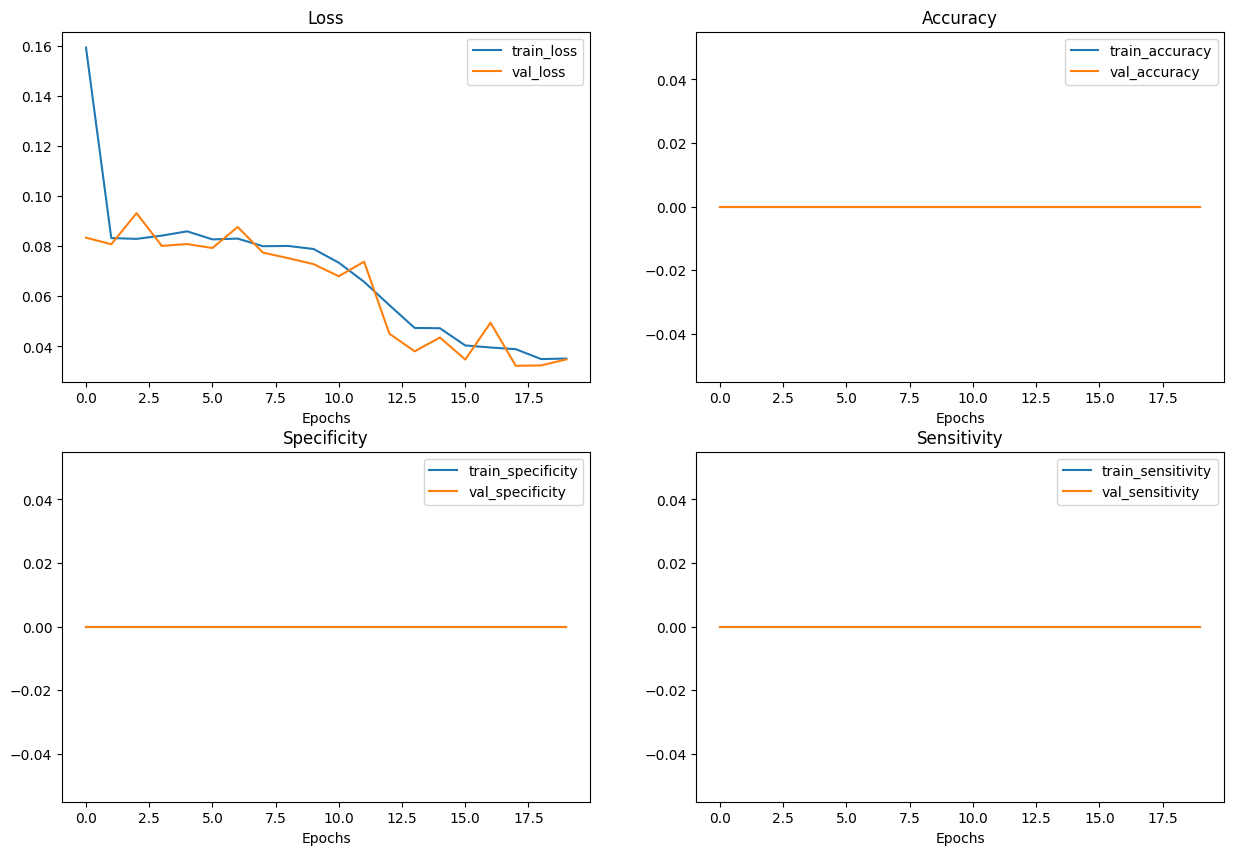

avg_train_loss_per_epoch: 0.0690 | avg_train_acc_per_epoch: 0.0000 | avg_train_spec_per_epoch: 0.0000 | avg_train_snv_per_epoch: 0.0000 |avg_val_loss_per_epoch: 0.0631 | avg_val_acc_per_epoch: 0.0000 |avg_val_spec_per_epoch: 0.0000 |avg_val_snv_per_epoch: 0.0000 |
Total training time: 16.306 seconds
Fold 2
Epoch: 1 | train_loss: 0.1606 | train_acc: 0.0000 | train_spec: 0.0000 train_snv: 0.0000 val_loss: 0.0805 | val_acc: 0.0000 |val_spec: 0.0000 |val_snv: 0.0000 |
Epoch: 2 | train_loss: 0.0821 | train_acc: 0.0000 | train_spec: 0.0000 train_snv: 0.0000 val_loss: 0.0757 | val_acc: 0.0000 |val_spec: 0.0000 |val_snv: 0.0000 |
Epoch: 3 | train_loss: 0.0800 | train_acc: 0.0000 | train_spec: 0.0000 train_snv: 0.0000 val_loss: 0.0779 | val_acc: 0.0000 |val_spec: 0.0000 |val_snv: 0.0000 |
Epoch: 4 | train_loss: 0.0812 | train_acc: 0.0000 | train_spec: 0.0000 train_snv: 0.0000 val_loss: 0.0841 | val_acc: 0.0000 |val_spec: 0.0000 |val_snv: 0.0000 |
Epoch: 5 | train_loss: 0.0785 | train_acc: 0.000

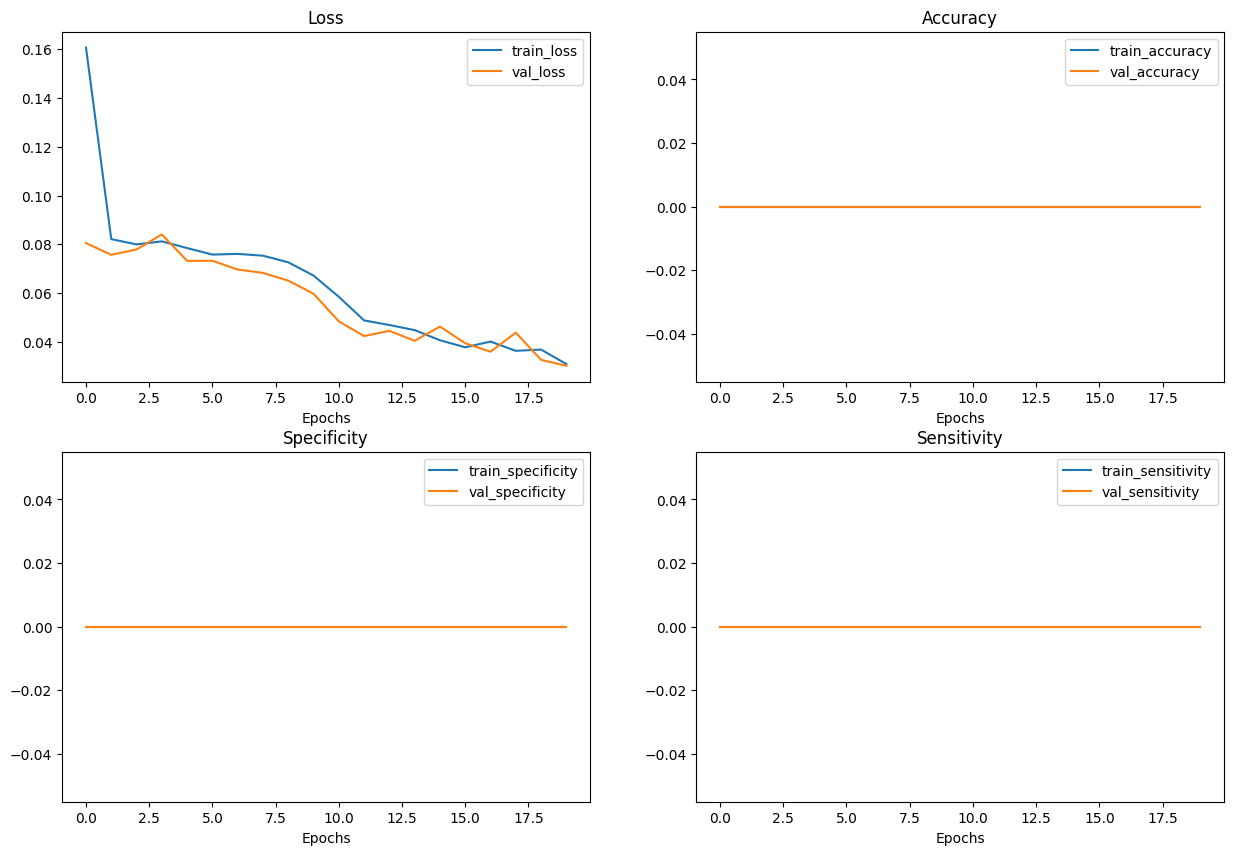

avg_train_loss_per_epoch: 0.0636 | avg_train_acc_per_epoch: 0.0000 | avg_train_spec_per_epoch: 0.0000 | avg_train_snv_per_epoch: 0.0000 |avg_val_loss_per_epoch: 0.0566 | avg_val_acc_per_epoch: 0.0000 |avg_val_spec_per_epoch: 0.0000 |avg_val_snv_per_epoch: 0.0000 |
Total training time: 15.741 seconds
Fold 3
Epoch: 1 | train_loss: 0.1522 | train_acc: 0.0000 | train_spec: 0.0000 train_snv: 0.0000 val_loss: 0.0817 | val_acc: 0.0000 |val_spec: 0.0000 |val_snv: 0.0000 |
Epoch: 2 | train_loss: 0.0834 | train_acc: 0.0000 | train_spec: 0.0000 train_snv: 0.0000 val_loss: 0.0892 | val_acc: 0.0000 |val_spec: 0.0000 |val_snv: 0.0000 |
Epoch: 3 | train_loss: 0.0833 | train_acc: 0.0000 | train_spec: 0.0000 train_snv: 0.0000 val_loss: 0.0823 | val_acc: 0.0000 |val_spec: 0.0000 |val_snv: 0.0000 |
Epoch: 4 | train_loss: 0.0791 | train_acc: 0.0000 | train_spec: 0.0000 train_snv: 0.0000 val_loss: 0.0800 | val_acc: 0.0000 |val_spec: 0.0000 |val_snv: 0.0000 |
Epoch: 5 | train_loss: 0.0837 | train_acc: 0.000

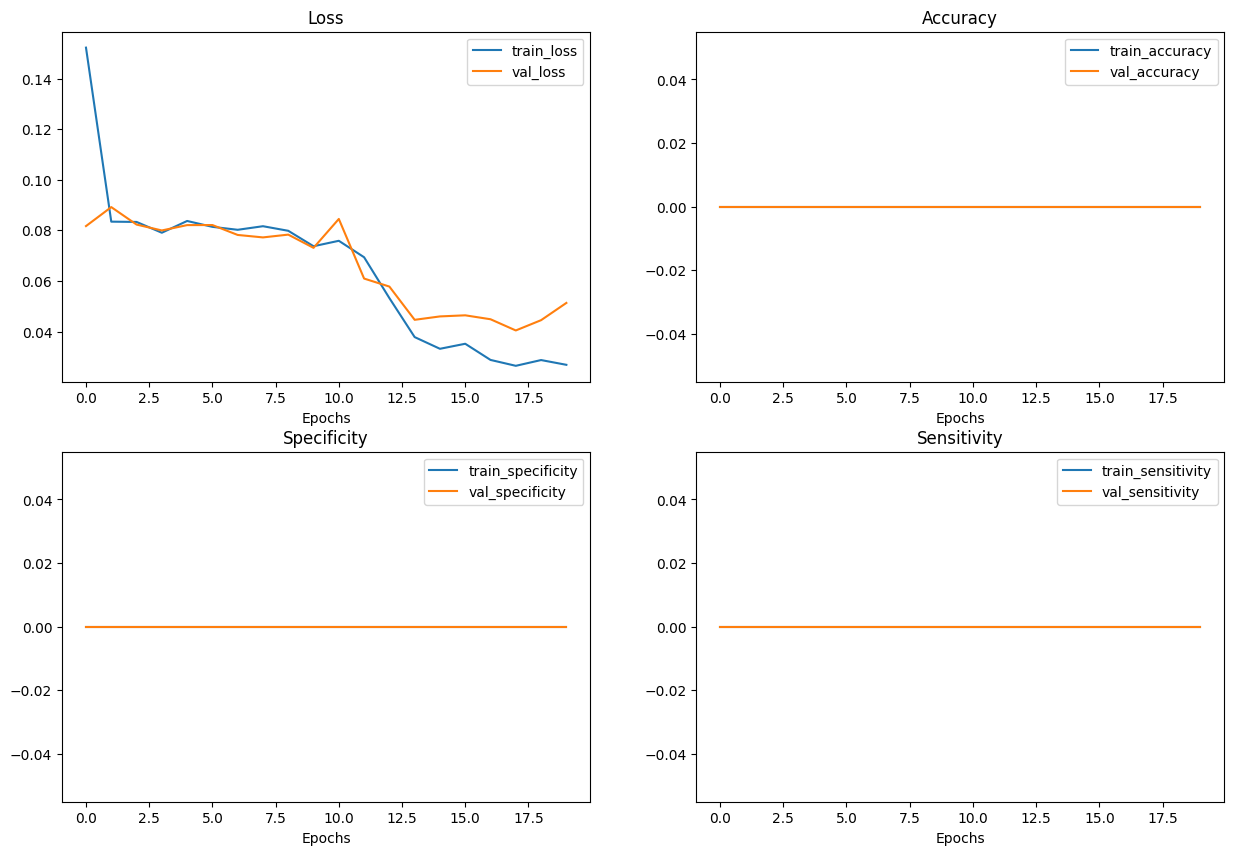

avg_train_loss_per_epoch: 0.0647 | avg_train_acc_per_epoch: 0.0000 | avg_train_spec_per_epoch: 0.0000 | avg_train_snv_per_epoch: 0.0000 |avg_val_loss_per_epoch: 0.0663 | avg_val_acc_per_epoch: 0.0000 |avg_val_spec_per_epoch: 0.0000 |avg_val_snv_per_epoch: 0.0000 |
Total training time: 15.902 seconds
avg_train_loss: 0.0658 | avg_train_acc: 0.0000 | avg_train_spec: 0.0000 | avg_train_snv: 0.0000 |avg_val_loss: 0.0620 | avg_val_acc: 0.0000 |avg_val_spec: 0.0000 |avg_val_snv: 0.0000 |


In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, StratifiedGroupKFold
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset, Subset
import torch.nn as nn 
k= 3   #len(np.unique(group))
window_size = 4
# splits=KFold(n_splits=k,shuffle=True,random_state=42)
splits=StratifiedKFold(n_splits=k,shuffle=True, random_state=42)
batch_size = 32
NUM_EPOCHS = 20
avg_train_loss_all_folds = []
avg_train_acc_all_folds = []
avg_train_spec_all_folds = []
avg_train_snv_all_folds = []
avg_val_loss_all_folds = []
avg_val_acc_all_folds = []
avg_val_spec_all_folds = []
avg_val_snv_all_folds = []
foldperf={}
result_for_weight_list = []
y_true_all_folds = []
y_pred_all_folds = []
k_fold_snv = []   # every fold gives an  averahe of all the epochs and avg of that will be the final value #########
#weight_list = [[1.0000, 95290/346], [0.5018, 138.2023], [1/95290, 1/346]]

for fold, (train_idx,val_idx) in enumerate(splits.split(X , y)):   #enumerate(splits.split(feature_tensor, label_tensor))  :  (splits.split(np.arange(len(dataset)))
    #print(len(train_idx), len(val_idx))
    print('Fold {}'.format(fold + 1))
    my_subset = Subset(dataset, train_idx)
    # validation_dataset = X[val_idx], y[val_idx]
    #print(len(dataset), len(my_subset))
    train_dataloader = DataLoader(my_subset, batch_size=batch_size, shuffle = True )
    train_mean, train_std = get_mean_and_std(train_dataloader)
    

    # val_dataloader = DataLoader(validation_dataset, batch_size=batch_size,  shuffle= True)
    #print(len(train_dataloader))#,len(val_dataloader))
    my_subset_val = Subset(dataset, val_idx)

    val_dataloader = DataLoader(my_subset_val, batch_size=batch_size, shuffle = True )
    # for i in range(len(train_dataloader)):
    
    # for i in range(len(train_dataloader)):
    #     _,y = next(iter(train_dataloader))
    #     if y.any() == 1:
    #         for l in range(len(y)):
    #             if l == 1:
    #                 c1+=1
    #             else:
    #                 c0+=1
    #     else:
    #         for l in range(len(y)):
    #             c0+=1
  
    # print('Ratio of 0 class count to 1 in training set in this epoch:', c0/c1)
    # for i in range(len(val_dataloader)):
    #     _,y = next(iter(val_dataloader))
    #     if y.any() == 1:
    #         for l in range(len(y)):
    #             if l == 1:
    #                 c1_val+=1
    #             else:
    #                 c0_val+=1
    #     else:
    #         for l in range(len(y)):
    #             c0_val+=1
    # print('Ratio of 0 class count to 1 in validation set in this epoch:', c0_val/c1_val)
    
    model_3 = CNN().to(device)

    weight = torch.FloatTensor([0.5082, 30.8219])    #1.0000, 47818/346])  1.0000, 216944/754    1.0000, 47818/346   1/47472, 1/346weight=torch.FloatTensor([ 0.7500, 1.5000])

    weight = weight.to(device)
    # Setup loss function and optimizer
    #loss_fn = nn.BCELoss(weight = weight)
    loss_fn = nn.CrossEntropyLoss()#weight = weight
    optimizer = torch.optim.Adam(params=model_3.parameters(), lr=1e-3) ########FROM 0.001 TO 0.01 DUE TO NAN LOSS VANISHING GRADIENTS#####, weight_decay=0.1)
    #, betas=(0.9, 0.999))

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()


    # Train model_0 
    model_results = train(train_mean, train_std, model=model_3, 
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        optimizer=optimizer, 
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)
    # for i in y_pred:
    #     print(type(i))
    # y_true_all_folds.append(y_true)
    # y_pred_all_folds.append(y_pred)
    plot_loss_curves(model_results)
    
    avg_train_loss_per_fold = np.mean(model_results["train_loss"])
    avg_train_acc_per_fold = np.mean(model_results["train_acc"])
    avg_train_spec_per_fold = np.mean(model_results["train_spec"])
    avg_train_snv_per_fold = np.mean(model_results["train_snv"])
    avg_val_loss_per_fold = np.mean(model_results["val_loss"])
    avg_val_acc_per_fold = np.mean(model_results["val_acc"])
    avg_val_spec_per_fold = np.mean(model_results["val_spec"])
    avg_val_snv_per_fold = np.mean(model_results["val_snv"])
    
    print(
            f"avg_train_loss_per_epoch: {avg_train_loss_per_fold:.4f} | "
            f"avg_train_acc_per_epoch: {avg_train_acc_per_fold:.4f} | "
            f"avg_train_spec_per_epoch: {avg_train_spec_per_fold:.4f} | "
            f"avg_train_snv_per_epoch: {avg_train_snv_per_fold:.4f} |"
            f"avg_val_loss_per_epoch: {avg_val_loss_per_fold:.4f} | "
            f"avg_val_acc_per_epoch: {avg_val_acc_per_fold:.4f} |"
            f"avg_val_spec_per_epoch: {avg_val_spec_per_fold:.4f} |"
            f"avg_val_snv_per_epoch: {avg_val_snv_per_fold:.4f} |"
        )


    

    # print(cv_results.mean(), cv_results.std())
# End the timer and print out how long it took
    end_time = timer()
    print(f"Total training time: {end_time-start_time:.3f} seconds")

    foldperf['fold{}'.format(fold+1)] =  avg_train_loss_per_fold, avg_train_acc_per_fold,avg_train_spec_per_fold,avg_train_snv_per_fold,avg_val_loss_per_fold,avg_val_acc_per_fold, avg_val_spec_per_fold,avg_val_snv_per_fold
    
    avg_train_loss_all_folds.append(avg_train_loss_per_fold)
    avg_train_acc_all_folds.append(avg_train_acc_per_fold)
    avg_train_spec_all_folds.append(avg_train_spec_per_fold)
    avg_train_snv_all_folds.append(avg_train_snv_per_fold)
    avg_val_loss_all_folds.append(avg_val_loss_per_fold)
    avg_val_acc_all_folds.append(avg_val_acc_per_fold)
    avg_val_spec_all_folds.append(avg_val_spec_per_fold)
    avg_val_snv_all_folds.append(avg_val_snv_per_fold)
    
    #model_3.reset_parameters()
    
    #result_for_weight_list.append([foldperf])
# y_true_df = pd.DataFrame(y_true_all_folds) 
# y_pred_df = pd.DataFrame(y_pred_all_folds)
# y_true_df.to_csv('y_true.csv')
# y_pred_df.to_csv('y_pred.csv') 
print(
    f"avg_train_loss: {np.mean(avg_train_loss_all_folds):.4f} | "
    f"avg_train_acc: {np.mean(avg_train_acc_all_folds):.4f} | "
    f"avg_train_spec: {np.mean(avg_train_spec_all_folds):.4f} | "
    f"avg_train_snv: {np.mean(avg_train_snv_all_folds):.4f} |"
    f"avg_val_loss: {np.mean(avg_val_loss_all_folds):.4f} | "
    f"avg_val_acc: {np.mean(avg_val_acc_all_folds):.4f} |"
    f"avg_val_spec: {np.mean(avg_val_spec_all_folds):.4f} |"
    f"avg_val_snv: {np.mean(avg_val_snv_all_folds):.4f} |"
)

torch.save(model_3,'5fold_2DCNN_filtered_50hz_normalized_infoldlr-3_nosampler_0-1_nogroup_pat1_9knetwork_class_weights.pt') 
# torch.save({
#             'model_state_dict': model_3.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             #'loss': LOSS,
#             }, '3fold_2DCNN_filtered_up0.1down0.3_classweights_lr-2.pt')   


In [ ]:
train_mean,train_std

(tensor(-4.0579e-07), tensor(0.2315))

In [ ]:
test_dataloader = DataLoader(dataset=test_dataset, # use custom created test Dataset
                                    #sampler = sampler,
                                    batch_size=32, 
                                    num_workers=4, 
                                    shuffle=False)

test_loss, test_acc, test_spec = val_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
print(
      f"test_loss: {test_loss:.4f} | "
      f"test_acc: {test_acc:.4f} | "
      f"test_spec: {test_spec:.4f} ")

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

'''
TP : the number of segments that are correctly identified as ictal (x_true == x_pred == 1)
TN : the number of EEG segments that are correctly classified as non-ictal (x_true == x_pred == 0)
FP : the number of EEG segments that are incorrectly classified as ictal (x_true == 0 && x_pred == 1)
FN : the segments that are incorrectly classified as non-ictal (x_true == 1 && x_pred == 0)
'''
def classificationPerformanceIndexes (true_arr, pred_arr):
    (tn, fp, fn, tp) = confusion_matrix(true_arr, pred_arr, labels=[0, 1]).ravel()
    acc = accuracy_score(true_arr, pred_arr)                           # Accuracy
    snv = tp/(tp + fn)                                                 # Sensitivity or True Positive Rate (TPR)
    spc = tn/(tn + fp)                                                 # Specificity or True Negative Rate (TNR)
    ppv = tp/(tp + fp)                                                 # Precision or Positive Predictive Value (PPV)
    f1 = f1_score(true_arr, pred_arr)                                  # F1 score
    #mcc = matthews_corrcoef(true_arr, pred_arr)                        # Matthews Correlation Coefficient
    #kappa = cohen_kappa_score(true_arr, pred_arr)                      # Cohen’s Kappa    
    return acc, snv, spc, ppv, f1

In [ ]:
def printClassificationPerformanceIndexes(acc, snv, spc, ppv, f1):
    #print('Method:', method)
    print('Accuracy:', acc)
    print('Sensitivity/Recall:', snv)
    print('Specificity:', spc)
    print('Precision:', ppv)
    print('F1 Score:', f1)
    #print('Matthews Correlation Coefficient:', mcc)
    #print('Cohen’s Kappa:', kappa)

In [ ]:
a= [0, 0, 0,0]
b = [0,0,0,0]
acc, snv, spc, ppv, f1 = classificationPerformanceIndexes(a, b)
printClassificationPerformanceIndexes(acc, snv, spc, ppv, f1)

Accuracy: 1.0
Sensitivity/Recall: 1.0
Specificity: 1.0
Precision: nan
F1 Score: 0.0


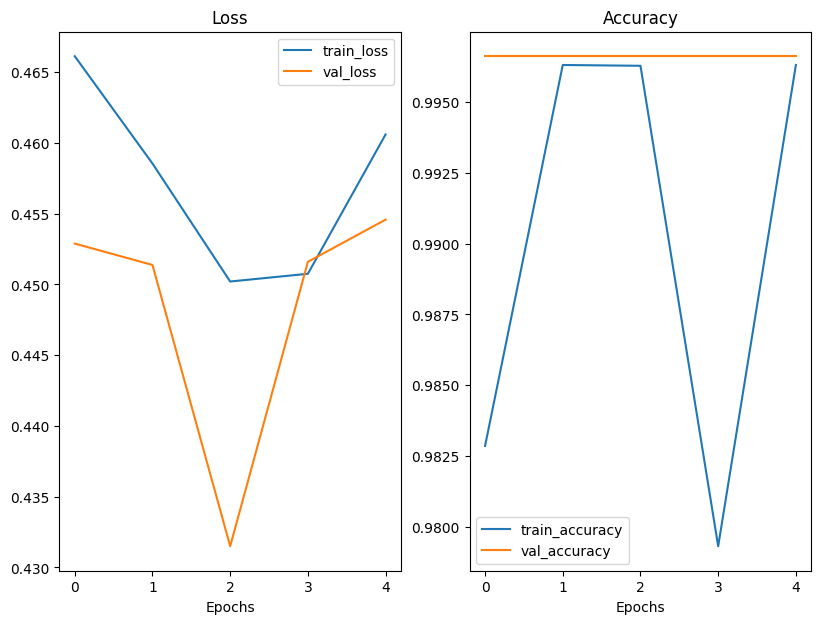

In [ ]:
def plot_loss_curves(results):
  #: Dict[str, List[float]]
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    losses = results['train_loss']
    losses_array= [loss for loss in losses]
    #loss.detach().numpy()
    #print(losses)
    val_losses = results['val_loss']
    #val_losses_array= [loss.detach().numpy() for loss in val_losses]
    val_losses_array= [loss for loss in val_losses]

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    #print(accuracy)
    val_accuracy = results['val_acc']

    # Get the specificity of the results dictionary (training and test)
    #specificity = results['train_spec']
    #specificity_array= [spec.cpu().numpy() for spec in specificity]
    #print(specificity_array)
    val_specificity = results['val_spec']
    val_specificity_array = [spec for spec in val_specificity]
    #val_specificity_array = [spec for spec in val_specificity]

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))
    #print(type(epochs))
    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, losses_array, label='train_loss')
    plt.plot(epochs, val_losses_array, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot specificity
    # plt.subplot(1, 3, 3)
    # plt.plot(epochs, specificity_array, label='train_specificity')
    # plt.plot(epochs, val_specificity_array, label='val_specificity')
    # plt.title('Specificity')
    # plt.xlabel('Epochs')
    # plt.legend()

plot_loss_curves(model_results)
plt.savefig('model_results_with_class_weights_1_2_3_4_5fold.png')


In [ ]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)


# Set number of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model = CNN(1024).to(device)
weight = torch.FloatTensor([1.0,23.0])
#weight = weight.type(torch.LongTensor)
weight = weight.to(device)
# Setup loss function and optimizer
#loss_fn = nn.BCELoss(weight = weight)
loss_fn = nn.CrossEntropyLoss(weight = weight)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
#, betas=(0.9, 0.999))

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
inputs.shape,labels_test.shape

((1481, 22, 1024), (1481,))

In [ ]:
import torch
model_1 = torch.load('5fold_2DCNN_filtered_50hz_normalized_infoldlr-3_nosampler_0-1_nogroup_pat1_9knetwork_class_weights.pt')
model_1.eval()
inputs = np.load('window_4/patient_specific/1/features_test_chb01.npy')
print(inputs.shape)
labels_test = np.load('window_4/patient_specific/1/labels_test_chb01.npy')
for i in range(len(labels_test)):
    if labels_test[i] == 1:
        print(labels_test[i])

feature_tensor_test = torch.Tensor(inputs)
feature_tensor_test = feature_tensor_test.unsqueeze(dim = 1)
print('features tensorshape ', feature_tensor_test.shape)
label_tensor_test = torch.Tensor(labels_test)
y_predictions = []
test_dataset = torch.utils.data.TensorDataset(feature_tensor_test, label_tensor_test)
test_dataloader = DataLoader(test_dataset, batch_size=32)
for batch, (X_test, y_test) in enumerate(test_dataloader):
            X_test = X_test.to(device)
            transform = T.Normalize(mean=(train_mean), std=(train_std))
            X_test = transform(X_test)
            X_test = torch.clamp(X_test, min=0,max=1)
            y_logits_test = model_1(X_test)
            #print('y_val shape',y_val.shape)
            #print('y_val_logits shape', y_logits_val.shape)
            #y_prob_test = torch.softmax(y_logits_test, dim=1)
            y_pred_test = torch.argmax(torch.softmax(y_logits_test, dim=1), dim=1)
            y_predictions.append(y_pred_test.cpu().tolist())
for j in range(len(y_predictions)):
    if np.any(y_predictions[j]) == 1:
        print(y_predictions[j])

c:\Users\TAACHUP2\Miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttributeError: Can't get attribute 'CNN' on <module '__main__'>

In [ ]:
def flatten(l):
    return [item for sublist in l for item in sublist]

[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

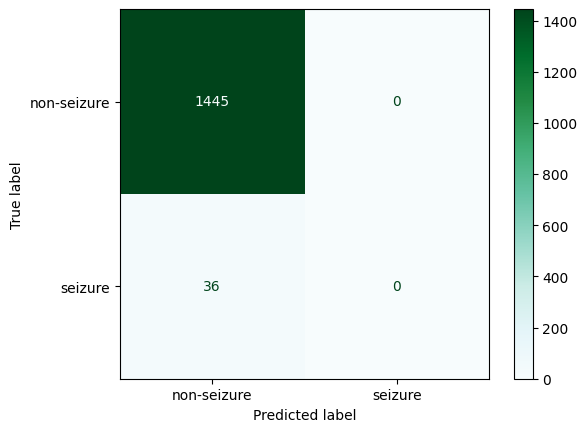

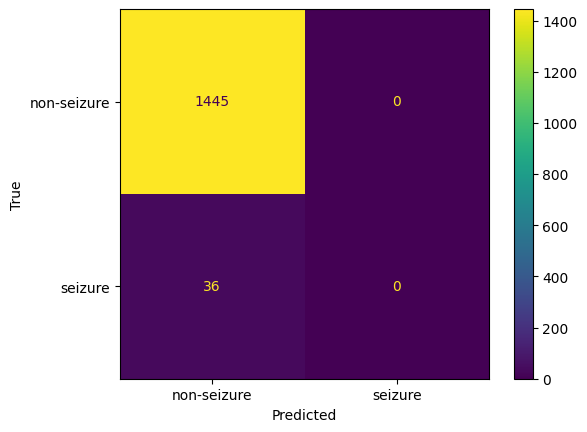

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#cm = confusion_matrix(labels_test, flatten(y_predictions))    #, normalize='all'cm, display_labels=['non-seizure','seizure']
cmd = ConfusionMatrixDisplay.from_predictions(labels_test, flatten(y_predictions), display_labels=['non-seizure','seizure'], cmap = 'BuGn')
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

In [ ]:
acc, snv, spc, ppv, f1= classificationPerformanceIndexes(labels_test, flatten(y_predictions))
printClassificationPerformanceIndexes(acc, snv, spc, ppv, f1)

NameError: name 'flatten' is not defined

In [ ]:
from sklearn.datasets import make_classification

x, y1 = make_classification(n_classes=2,
weights=[0.9,0.1 ], random_state=10)
counter = Counter(y1)
print(counter)
# x = torch.Tensor(x)
# y1 = torch.Tensor(y1)

Counter({0: 90, 1: 10})


In [ ]:
class_weights=sklearn.utils.class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(y1),y =y1)
class_weights=torch.tensor(class_weights,dtype=torch.float)
print(class_weights)


tensor([0.5556, 5.0000])


In [ ]:
x = torch.Tensor(x)
y1 = torch.Tensor(y1)
criterion_weighted = nn.CrossEntropyLoss(weight=class_weights,reduction='mean')
loss_weighted = criterion_weighted(x, y1)

RuntimeError: weight tensor should be defined either for all 20 classes or no classes but got weight tensor of shape: [2]